**Introduction to Artificial Neural Networks with Keras**

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [117]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import os
import pandas as pd


import tensorflow as tf



# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import reciprocal

%pip install tensorflow
%pip install scikeras

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [118]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.datasets import load_iris, fetch_california_housing
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasRegressor


from keras.saving import register_keras_serializable

In [3]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.0
except Exception:
    pass

# TensorFlow ≥2.0 is required
#import tensorflow as tf
assert tf.__version__ >= "2.0"

#from tensorflow import keras

In [4]:
tf.__version__

'2.19.0'

In [5]:
keras.__version__

'3.10.0'

In [6]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "../../."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Perceptrons

**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

In [7]:
iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [8]:
y_pred

array([1])

Saving figure perceptron_iris_plot


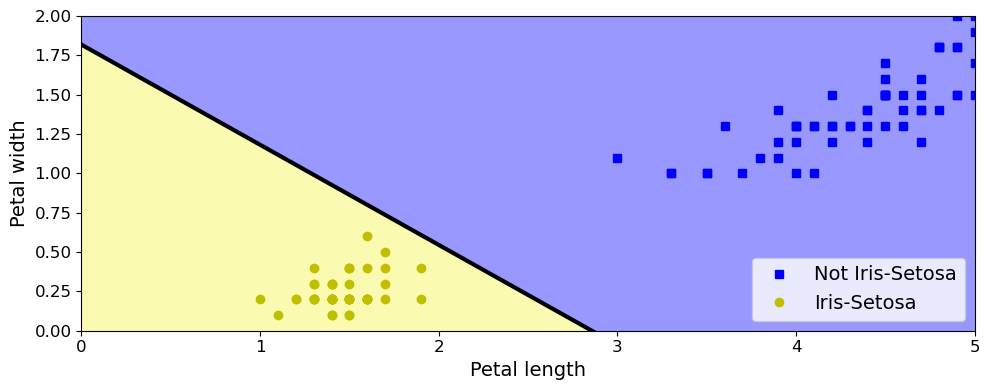

In [9]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Activation functions

In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


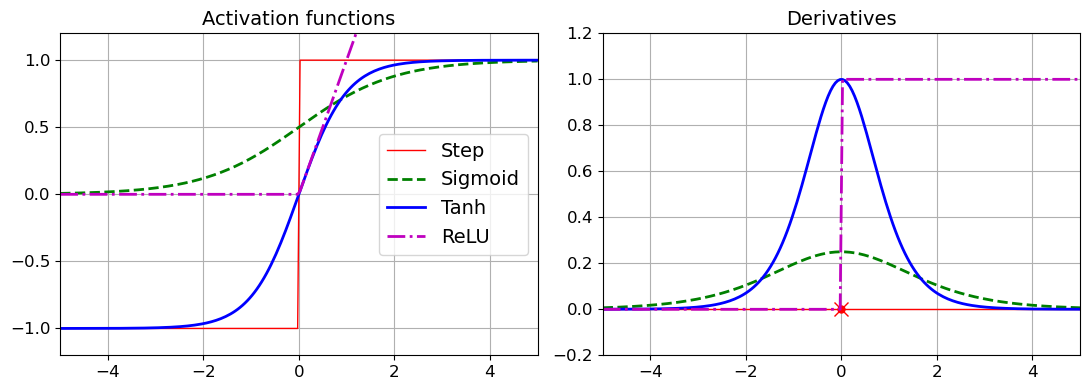

In [11]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

In [12]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

In [13]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Building an Image Classifier

In [14]:
import tensorflow as tf
from tensorflow import keras

In [15]:
tf.__version__

'2.19.0'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [16]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [17]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [18]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [19]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

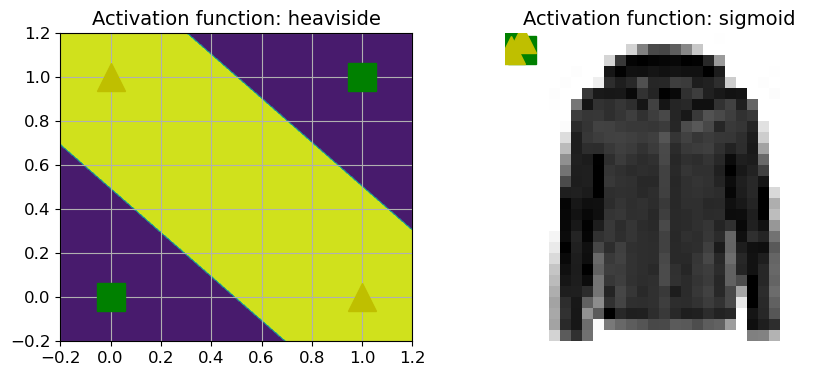

In [20]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [21]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [22]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [23]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [24]:
X_valid.shape

(5000, 28, 28)

In [25]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


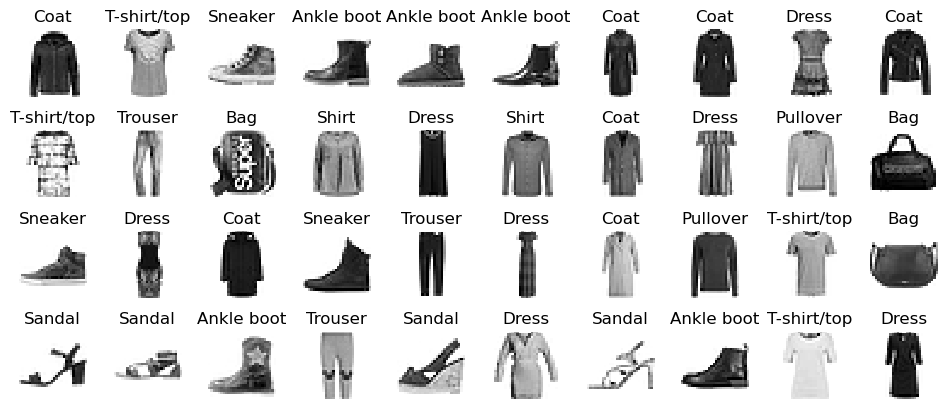

In [26]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [27]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

/Users/m5/Desktop/anaconda3/envs/med2/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [29]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [30]:
model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [33]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [34]:
model.get_layer(hidden1.name) is hidden1

True

In [35]:
weights, biases = hidden1.get_weights()

In [36]:
weights

array([[-0.01171021, -0.02066572, -0.05509927, ...,  0.07118452,
         0.06048612,  0.03034008],
       [-0.02138305,  0.04805603,  0.00834843, ...,  0.04145984,
         0.01259613,  0.06166665],
       [ 0.06668028,  0.04394695, -0.06866848, ..., -0.06334381,
         0.00048717,  0.07315403],
       ...,
       [ 0.06922527, -0.01551912,  0.00756883, ..., -0.02064191,
         0.0357802 , -0.07172526],
       [ 0.01822765, -0.057161  , -0.00453375, ...,  0.03968978,
        -0.01069692,  0.01035156],
       [ 0.00955996,  0.03673504, -0.00439651, ..., -0.03481197,
        -0.00832947, -0.00655732]], dtype=float32)

In [37]:
weights.shape

(784, 300)

In [38]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [39]:
biases.shape

(300,)

In [40]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [41]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6801 - loss: 0.9906 - val_accuracy: 0.8196 - val_loss: 0.5268
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8232 - loss: 0.5055 - val_accuracy: 0.8450 - val_loss: 0.4585
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8416 - loss: 0.4504 - val_accuracy: 0.8562 - val_loss: 0.4226
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8535 - loss: 0.4199 - val_accuracy: 0.8616 - val_loss: 0.4015
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8598 - loss: 0.3984 - val_accuracy: 0.8674 - val_loss: 0.3854
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8658 - loss: 0.3815 - val_accuracy: 0.8686 - val_loss: 0.3736
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8697 - loss: 0.3674 - val_accuracy: 0.8738 - val_loss: 0.3637
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8737 - loss: 0.3552 - 

In [42]:
history.params

{'verbose': 'auto', 'epochs': 30, 'steps': 1719}

In [43]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [44]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Saving figure keras_learning_curves_plot


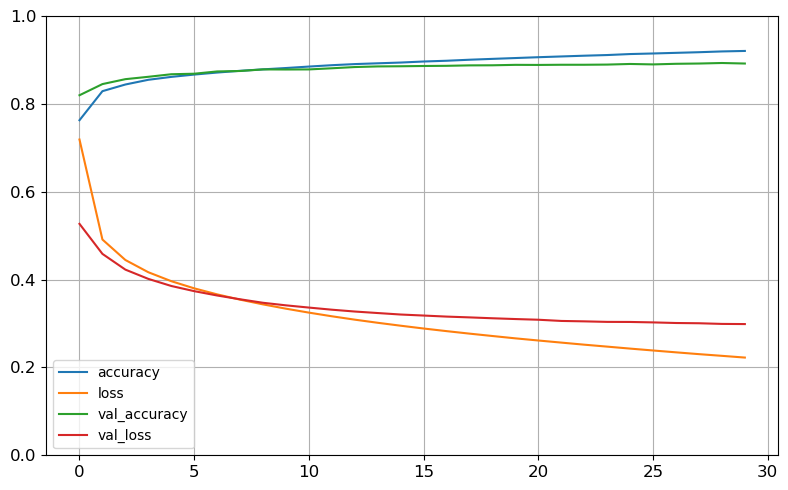

In [45]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [46]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.8766 - loss: 0.3464


[0.3454381823539734, 0.8769999742507935]

In [47]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

**Warning**: `model.predict_classes(X_new)` is deprecated. It is replaced with `np.argmax(model.predict(X_new), axis=-1)`.

In [48]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


array([9, 2, 1])

In [49]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [50]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


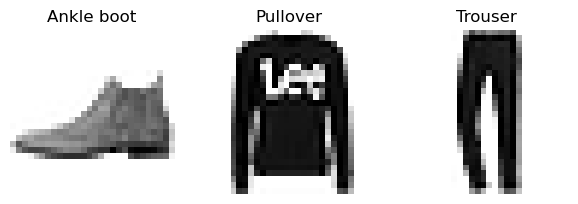

In [51]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the California housing dataset:

In [52]:
housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

In [54]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20


/Users/m5/Desktop/anaconda3/envs/med2/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.3009 - val_loss: 0.9575
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 0.8329 - val_loss: 0.7070
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 0.7180 - val_loss: 0.6188
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 0.6660 - val_loss: 0.5802
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 0.6278 - val_loss: 0.5498
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 0.5980 - val_loss: 0.5261
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 0.5744 - val_loss: 0.5069
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 0.5553 - val_loss: 0.4913
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 0.5395 - val_loss: 0.4782
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.5262 - val_loss: 0.4671
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 0.5147 - val_loss: 0.4577
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s

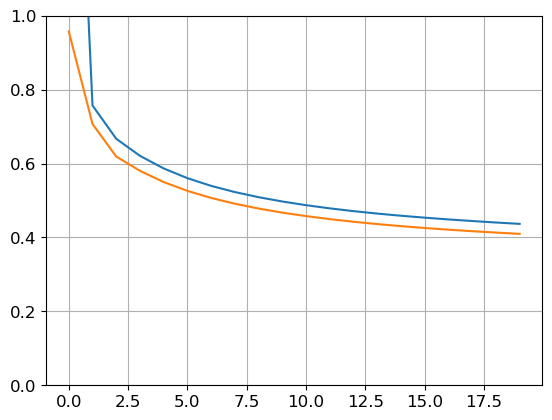

In [55]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [56]:
y_pred

array([[0.503139 ],
       [1.5406499],
       [3.3972468]], dtype=float32)

# Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

In [58]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [59]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 30)        │        270 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 30)        │        930 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38)        │          0 │ input_layer_2[0]… │
│ (Concatenate)       │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         39 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,239 (4.84 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.8412 - val_loss: 1.2962
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 0.7987 - val_loss: 0.7930
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 0.7162 - val_loss: 0.6312
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 0.6588 - val_loss: 0.5943
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.6157 - val_loss: 0.5539
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.5819 - val_loss: 0.5258
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5548 - val_loss: 0.5038
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 0.5327 - val_loss: 0.4859
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 0.5145 - val_loss: 0.4711
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4992 - val_loss: 0.4584
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 0.4865 - val_loss: 0.4473
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [61]:
np.random.seed(42)
tf.random.set_seed(42)

In [62]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [63]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.7301 - val_loss: 2.1382
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 0.9826 - val_loss: 0.7794
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 0.7416 - val_loss: 0.6460
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.6612 - val_loss: 0.5884
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 0.6156 - val_loss: 0.5528
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.5824 - val_loss: 0.5259
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5562 - val_loss: 0.5038
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 0.5346 - val_loss: 0.4854
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 0.5170 - val_loss: 0.4693
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 0.5026 - val_loss: 0.4564
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.4910 - val_loss: 0.4456
Epoch 12/20
363/363 ━━━━━━━━━━━━━━

Adding an auxiliary output for regularization:

In [64]:
np.random.seed(42)
tf.random.set_seed(42)

In [65]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [66]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [67]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - aux_output_loss: 5.4923 - loss: 5.6548 - main_output_loss: 5.6729 - val_aux_output_loss: 5.9972 - val_loss: 3.6681 - val_main_output_loss: 3.4079
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - aux_output_loss: 3.9602 - loss: 1.5187 - main_output_loss: 1.2474 - val_aux_output_loss: 7.1787 - val_loss: 2.0075 - val_main_output_loss: 1.4322
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - aux_output_loss: 2.7896 - loss: 1.0070 - main_output_loss: 0.8089 - val_aux_output_loss: 9.5042 - val_loss: 1.5469 - val_main_output_loss: 0.6622
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - aux_output_loss: 2.1718 - loss: 0.8443 - main_output_loss: 0.6968 - val_aux_output_loss: 8.8208 - val_loss: 1.5024 - val_main_output_loss: 0.6886
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - aux_output_loss: 1.8296 - loss: 0.7690 - main_output_loss: 0.6512 - val_aux_output_loss: 7.8825 - val_loss: 1.3209 - val_main_output_loss: 0.5912


In [68]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - aux_output_loss: 0.9283 - loss: 0.4919 - main_output_loss: 0.4434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


# The subclassing API

In [69]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        #return main_output, aux_output
        return {"main_output": main_output, "aux_output": aux_output}
        

model = WideAndDeepModel(30, activation="relu")

In [70]:
# Test what the model returns
output = model((X_train_A[:1], X_train_B[:1]))
print("Model output type:", type(output))
print("Length of output:", len(output) if isinstance(output, (list, tuple)) else "Not a list/tuple")


Model output type: <class 'dict'>
Length of output: Not a list/tuple


In [71]:
#model((X_train_A[:1], X_train_B[:1]))
#model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
#history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
 #                   validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
#total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
#y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))



model = WideAndDeepModel()

model((X_train_A[:1], X_train_B[:1]))  # build model

model.compile(
    loss={"main_output": "mse", "aux_output": "mse"},
    loss_weights={"main_output": 0.9, "aux_output": 0.1},
    optimizer=keras.optimizers.SGD(learning_rate=1e-3)
)

history = model.fit(
    (X_train_A, X_train_B),
    {"main_output": y_train, "aux_output": y_train},
    epochs=10,
    validation_data=((X_valid_A, X_valid_B), {"main_output": y_valid, "aux_output": y_valid})
)

total_loss, main_loss, aux_loss = model.evaluate(
    (X_test_A, X_test_B),
    {"main_output": y_test, "aux_output": y_test}
)

y_pred = model.predict((X_new_A, X_new_B))
y_pred_main = y_pred["main_output"]
y_pred_aux = y_pred["aux_output"]



Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - aux_output_loss: 4.4794 - loss: 3.9803 - main_output_loss: 3.9249 - val_aux_output_loss: 6.5393 - val_loss: 2.1549 - val_main_output_loss: 1.6669
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - aux_output_loss: 2.5503 - loss: 1.1101 - main_output_loss: 0.9501 - val_aux_output_loss: 5.2520 - val_loss: 1.2367 - val_main_output_loss: 0.7902
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - aux_output_loss: 1.9484 - loss: 0.8972 - main_output_loss: 0.7804 - val_aux_output_loss: 4.8989 - val_loss: 1.0993 - val_main_output_loss: 0.6767
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - aux_output_loss: 1.6731 - loss: 0.8206 - main_output_loss: 0.7259 - val_aux_output_loss: 4.7446 - val_loss: 1.0686 - val_main_output_loss: 0.6597
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - aux_output_loss: 1.5339 - loss: 0.7750 - main_output_loss: 0.6907 - val_aux_output_loss: 4.6067 - val_loss: 1.0427 - val_main_output_loss: 0.646

# Saving and Restoring

In [72]:
np.random.seed(42)
tf.random.set_seed(42)

In [73]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [74]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.8950 - val_loss: 0.9341
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 0.8805 - val_loss: 0.7769
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 0.7860 - val_loss: 0.7110
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.7422 - val_loss: 0.6632
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.7030 - val_loss: 0.6208
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.6644 - val_loss: 0.5812
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.6267 - val_loss: 0.5451
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5901 - val_loss: 0.5106
Epoch 9/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 0.5577 - val_loss: 0.4824
Epoch 10/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.5312 - val_loss: 0.4614
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 0.4906


In [75]:
model.save("my_keras_model.h5")

In [81]:



model = keras.models.load_model(
    "my_keras_model.h5",
    custom_objects={"WideAndDeepModel": WideAndDeepModel},
    compile=False
)



In [ ]:
model = keras.models.load_model("my_keras_model.h5", custom_objects={"mse": keras.losses.MeanSquaredError()})


#The error indicates that the mse function is not properly registered as a Keras serializable object. To fix this, you need to ensure that the mse function is correctly
#referenced when loading the model. You can use keras.losses.mean_squared_error instead of 'mse'.

In [82]:
model.predict(X_new)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


array([[0.7835251],
       [1.6590402],
       [3.0849247]], dtype=float32)

In [83]:
#model.save_weights("my_keras_weights.ckpt")

#in keras 3, when saving weights, the file extension should be .h5
model.save_weights("my_keras_weights.weights.h5")


In [84]:
model.load_weights("my_keras_weights.weights.h5")


# Using Callbacks during Training

In [85]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [86]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

/Users/m5/Desktop/anaconda3/envs/med2/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Ensure necessary imports

# Compile the model
#model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
# the above comment was a piece of code that could not be run because of the use of "mse " instead of keras.losses.MeanSquaredError()
model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.SGD(learning_rate=1e-3))


# Define a checkpoint callback
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])

# Load the best model
model = keras.models.load_model("my_keras_model.h5")  # rollback to best model

# Evaluate the model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
270/363 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 0.4307

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4250 - val_loss: 0.3855
Epoch 2/10
282/363 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 0.4264

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.4216 - val_loss: 0.3833
Epoch 3/10
357/363 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 0.4187

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - loss: 0.4184 - val_loss: 0.3812
Epoch 4/10
283/363 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 0.4198

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.4154 - val_loss: 0.3791
Epoch 5/10
347/363 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.4133

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 0.4126 - val_loss: 0.3771
Epoch 6/10
282/363 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 0.4143

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.4101 - val_loss: 0.3754
Epoch 7/10
355/363 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 0.4081

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 0.4077 - val_loss: 0.3736
Epoch 8/10
279/363 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 0.4098

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 0.4056 - val_loss: 0.3719
Epoch 9/10
275/363 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.4078

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 0.4035 - val_loss: 0.3702
Epoch 10/10
287/363 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 0.4053

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 0.4016 - val_loss: 0.3686


162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 0.3844


In [90]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
272/363 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 0.4040

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3998 - val_loss: 0.3670
Epoch 2/100
282/363 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 0.4018

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 0.3980 - val_loss: 0.3654
Epoch 3/100
268/363 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 0.4007

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 0.3964 - val_loss: 0.3641
Epoch 4/100
276/363 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.3988

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 0.3949 - val_loss: 0.3626
Epoch 5/100
269/363 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 0.3976

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.3935 - val_loss: 0.3615
Epoch 6/100
281/363 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 0.3957

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 0.3921 - val_loss: 0.3601
Epoch 7/100
272/363 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 0.3947

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 0.3907 - val_loss: 0.3590
Epoch 8/100
276/363 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 0.3932

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 0.3894 - val_loss: 0.3580
Epoch 9/100
359/363 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 0.3883

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 0.3882 - val_loss: 0.3569
Epoch 10/100
336/363 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 0.3880

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 0.3869 - val_loss: 0.3558
Epoch 11/100
361/363 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 0.3859

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 0.3858 - val_loss: 0.3545
Epoch 12/100
280/363 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 0.3881

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 0.3846 - val_loss: 0.3534
Epoch 13/100
343/363 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.3842

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 0.3835 - val_loss: 0.3525
Epoch 14/100
282/363 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 0.3857

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 0.3824 - val_loss: 0.3515
Epoch 15/100
334/363 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 0.3824

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.3813 - val_loss: 0.3505
Epoch 16/100
284/363 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.3834

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.3801 - val_loss: 0.3495
Epoch 17/100
271/363 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 0.3827

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 0.3791 - val_loss: 0.3486
Epoch 18/100
282/363 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 0.3813

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 0.3780 - val_loss: 0.3478
Epoch 19/100
268/363 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.3807

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 0.3770 - val_loss: 0.3469
Epoch 20/100
287/363 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 0.3792

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 0.3761 - val_loss: 0.3462
Epoch 21/100
307/363 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 0.3774

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 0.3752 - val_loss: 0.3455
Epoch 22/100
284/363 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 0.3775

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 0.3743 - val_loss: 0.3447
Epoch 23/100
273/363 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 0.3769

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.3735 - val_loss: 0.3440
Epoch 24/100
352/363 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 0.3730

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 0.3726 - val_loss: 0.3434
Epoch 25/100
275/363 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.3752

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 0.3718 - val_loss: 0.3427
Epoch 26/100
285/363 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.3741

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 0.3711 - val_loss: 0.3421
Epoch 27/100
271/363 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 0.3738

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 0.3703 - val_loss: 0.3415
Epoch 28/100
275/363 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 0.3729

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 0.3696 - val_loss: 0.3409
Epoch 29/100
288/363 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.3718

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 0.3688 - val_loss: 0.3404
Epoch 30/100
282/363 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 0.3713

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.3681 - val_loss: 0.3399
Epoch 31/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 0.3675

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 0.3675 - val_loss: 0.3393
Epoch 32/100
275/363 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 0.3701

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 0.3668 - val_loss: 0.3387
Epoch 33/100
333/363 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 0.3673

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 0.3662 - val_loss: 0.3382
Epoch 34/100
284/363 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 0.3686

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.3656 - val_loss: 0.3377
Epoch 35/100
330/363 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 0.3662

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 0.3650 - val_loss: 0.3372
Epoch 36/100
286/363 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 0.3673

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 0.3643 - val_loss: 0.3367
Epoch 37/100
289/363 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 0.3666

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 0.3637 - val_loss: 0.3363
Epoch 38/100
351/363 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 0.3636

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 0.3632 - val_loss: 0.3357
Epoch 39/100
275/363 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 0.3659

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 0.3626 - val_loss: 0.3355
Epoch 40/100
343/363 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 0.3627

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3620 - val_loss: 0.3350
Epoch 41/100
325/363 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 0.3628

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 0.3614 - val_loss: 0.3345
Epoch 42/100
281/363 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 0.3639

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 0.3608 - val_loss: 0.3341
Epoch 43/100
267/363 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 0.3638

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 0.3603 - val_loss: 0.3338
Epoch 44/100
282/363 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 0.3629

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 0.3598 - val_loss: 0.3333
Epoch 45/100
280/363 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 0.3624

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 0.3593 - val_loss: 0.3329
Epoch 46/100
284/363 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.3618

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 0.3588 - val_loss: 0.3325
Epoch 47/100
321/363 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 0.3598

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 0.3583 - val_loss: 0.3322
Epoch 48/100
278/363 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.3610

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.3578 - val_loss: 0.3318
Epoch 49/100
317/363 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 0.3591

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 0.3573 - val_loss: 0.3314
Epoch 50/100
344/363 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.3575

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 0.3569 - val_loss: 0.3310
Epoch 51/100
267/363 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 0.3600

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 0.3564 - val_loss: 0.3307
Epoch 52/100
283/363 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 0.3590

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 0.3559 - val_loss: 0.3303
Epoch 53/100
298/363 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 0.3581

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 0.3555 - val_loss: 0.3299
Epoch 54/100
277/363 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.3583

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 0.3550 - val_loss: 0.3294
Epoch 55/100
287/363 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.3576

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 0.3546 - val_loss: 0.3291
Epoch 56/100
281/363 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 0.3573

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 0.3541 - val_loss: 0.3287
Epoch 57/100
268/363 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 0.3572

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step - loss: 0.3537 - val_loss: 0.3283
Epoch 58/100
286/363 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 0.3562

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.3532 - val_loss: 0.3279
Epoch 59/100
286/363 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.3557

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 0.3527 - val_loss: 0.3275
Epoch 60/100
280/363 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 0.3554

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.3522 - val_loss: 0.3272
Epoch 61/100
359/363 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 0.3519

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.3517 - val_loss: 0.3268
Epoch 62/100
282/363 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 0.3544

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.3512 - val_loss: 0.3264
Epoch 63/100
293/363 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 0.3535

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 0.3508 - val_loss: 0.3260
Epoch 64/100
282/363 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 0.3534

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 0.3503 - val_loss: 0.3256
Epoch 65/100
272/363 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 0.3532

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 0.3498 - val_loss: 0.3253
Epoch 66/100
278/363 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 0.3525

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.3493 - val_loss: 0.3249
Epoch 67/100
324/363 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 0.3503

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.3489 - val_loss: 0.3246
Epoch 68/100
284/363 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.3515

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 0.3484 - val_loss: 0.3243
Epoch 69/100
361/363 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 0.3481

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 0.3480 - val_loss: 0.3239
Epoch 70/100
285/363 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 0.3506

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 0.3476 - val_loss: 0.3236
Epoch 71/100
273/363 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 0.3505

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 0.3471 - val_loss: 0.3233
Epoch 72/100
300/363 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 0.3492

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 0.3467 - val_loss: 0.3230
Epoch 73/100
289/363 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 0.3491

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 0.3463 - val_loss: 0.3227
Epoch 74/100
281/363 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 0.3489

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.3458 - val_loss: 0.3224
Epoch 75/100
286/363 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 0.3484

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 0.3454 - val_loss: 0.3222
Epoch 76/100
281/363 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 0.3481

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 0.3450 - val_loss: 0.3219
Epoch 77/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 0.3446

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 0.3446 - val_loss: 0.3216
Epoch 78/100
280/363 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - loss: 0.3472

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.3441 - val_loss: 0.3214
Epoch 79/100
266/363 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 0.3472

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 0.3437 - val_loss: 0.3211
Epoch 80/100
278/363 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.3465

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 0.3433 - val_loss: 0.3208
Epoch 81/100
269/363 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.3464

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 0.3429 - val_loss: 0.3205
Epoch 82/100
342/363 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.3433

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 0.3426 - val_loss: 0.3202
Epoch 83/100
351/363 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 0.3426

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 0.3422 - val_loss: 0.3199
Epoch 84/100
283/363 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 0.3448

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 0.3418 - val_loss: 0.3198
Epoch 85/100
296/363 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 0.3440

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.3414 - val_loss: 0.3194
Epoch 86/100
269/363 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 0.3445

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 0.3411 - val_loss: 0.3192
Epoch 87/100
282/363 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.3437

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 0.3407 - val_loss: 0.3191
Epoch 88/100
277/363 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 0.3435

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.3403 - val_loss: 0.3188
Epoch 89/100
287/363 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.3429

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.3400 - val_loss: 0.3187
Epoch 90/100
279/363 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 0.3427

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.3396 - val_loss: 0.3184
Epoch 91/100
353/363 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 0.3396

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3393 - val_loss: 0.3182
Epoch 92/100
275/363 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - loss: 0.3421

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 0.3389 - val_loss: 0.3181
Epoch 93/100
362/363 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 0.3386

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 0.3386 - val_loss: 0.3179
Epoch 94/100
280/363 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 0.3413

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 0.3382 - val_loss: 0.3178
Epoch 95/100
276/363 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 0.3410

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.3379 - val_loss: 0.3176
Epoch 96/100
279/363 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 0.3406

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 0.3376 - val_loss: 0.3175
Epoch 97/100
277/363 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 0.3403

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 0.3372 - val_loss: 0.3171
Epoch 98/100
274/363 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 0.3401

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 0.3369 - val_loss: 0.3171
Epoch 99/100
286/363 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.3394

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 0.3366 - val_loss: 0.3168
Epoch 100/100
335/363 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 0.3372

363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.3362 - val_loss: 0.3167
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 0.3304


In [91]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [92]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

344/363 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 0.3365
val/train: 0.97
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 0.3359 - val_loss: 0.3166


# TensorBoard

In [93]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [94]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2025_06_26-18_39_13'

In [95]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [96]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

/Users/m5/Desktop/anaconda3/envs/med2/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [97]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.3650 - val_loss: 0.9125
Epoch 2/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 0.7273 - val_loss: 0.5629
Epoch 3/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 0.6068 - val_loss: 0.5092
Epoch 4/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 0.5525 - val_loss: 0.4757
Epoch 5/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 0.5176 - val_loss: 0.4517
Epoch 6/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 0.4932 - val_loss: 0.4350
Epoch 7/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 0.4756 - val_loss: 0.4228
Epoch 8/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4622 - val_loss: 0.4141
Epoch 9/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 0.4521 - val_loss: 0.4083
Epoch 10/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 0.4440 - val_loss: 0.4043
Epoch 11/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 0.4372 - val_loss: 0.4005
Epoch 12/30
363/363 ━━━━━━━━━━━━━━

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [100]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 31247), started 0:01:54 ago. (Use '!kill 31247' to kill it.)

In [101]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2025_06_26-18_41_55'

In [102]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [103]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

/Users/m5/Desktop/anaconda3/envs/med2/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [104]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8457 - val_loss: 34.9428
Epoch 2/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 0.5354 - val_loss: 9.2877
Epoch 3/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 0.4363 - val_loss: 6.3282
Epoch 4/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: nan - val_loss: nan
Epoch 5/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: nan - val_loss: nan
Epoch 6/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: nan - val_loss: nan
Epoch 7/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - val_loss: nan
Epoch 8/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 9/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: nan - val_loss: nan
Epoch 10/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: nan - val_loss: nan
Epoch 11/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: nan - val_loss: nan
Epoch 12/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: nan - val_loss: nan


Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [105]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module keras.src.callbacks.tensorboard:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, write_steps_per_second=False, update_freq='epoch', profile_batch=0, embeddings_freq=0, embeddings_metadata=None)
    Initialize self.  See help(type(self)) for accurate signature.



# Hyperparameter Tuning

In [106]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [107]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [119]:



#this code will not run in keras 3, as the KerasRegressor class has been removed
#keras.wrappers.scikit_learn.KerasRegressor is not available in keras
#instead in will use scikeras which i will have to install

#keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


keras_reg = KerasRegressor(model=build_model, epochs=10)


In [121]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100


/Users/m5/Desktop/anaconda3/envs/med2/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.8429 - val_loss: 0.6023
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.6290 - val_loss: 0.5211
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 0.5529 - val_loss: 0.4640
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 0.5048 - val_loss: 0.4301
Epoch 5/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 0.4751 - val_loss: 0.4139
Epoch 6/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 0.4564 - val_loss: 0.4074
Epoch 7/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.4443 - val_loss: 0.4048
Epoch 8/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.4358 - val_loss: 0.4031
Epoch 9/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 0.4300 - val_loss: 0.4008
Epoch 10/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 0.4253 - val_loss: 0.3983
Epoch 11/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4214 - val_loss: 0.3952
Epoch 12/100
363/363 ━━━━━━━━━━━━━━

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

KerasRegressor(
	model=<function build_model at 0x1779dfb50>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
)

In [122]:
mse_test = keras_reg.score(X_test, y_test)

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step


In [123]:
y_pred = keras_reg.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [124]:
np.random.seed(42)
tf.random.set_seed(42)

**Warning**: the following cell crashes at the end of training. This seems to be caused by [Keras issue #13586](https://github.com/keras-team/keras/issues/13586), which was triggered by a recent change in Scikit-Learn. [Pull Request #13598](https://github.com/keras-team/keras/pull/13598) seems to fix the issue, so this problem should be resolved soon. In the meantime, I've added `.tolist()` and `.rvs(1000).tolist()` as workarounds.

In [ ]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100)               .tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2)      .rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3827 - val_loss: 0.4703
Epoch 2/100
242/242 [==============================] - 0s 757us/step - loss: 0.4880 - val_loss: 0.4247
Epoch 3/100
242/242 [==============================] - 0s 765us/step - loss: 0.4541 - val_loss: 0.4052
Epoch 4/100
242/242 [==============================] - 0s 745us/step - loss: 0.4518 - val_loss: 0.3975
Epoch 5/100
242/242 [==============================] - 0s 765us/step - loss: 0.4337 - val_loss: 0.3991
Epoch 6/100
242/242 [==============================] - 0s 751us/step - loss: 0.4263 - val_loss: 0.4031
Epoch 7/100
242/242 [==============================] - 0s 743us/step - loss: 0.4385 - val_loss: 0.4043
Epoch 8/100
242/242 [==============================] - 0s 780us/step - loss: 0.4301 - val_loss: 0.3929
Epoch 9/100
242/242 [==============================] - 0s 792us/step - loss: 0.4108 - val_loss: 0.4040
Epoch 10/100
2

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd939643c10>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302,
                                                          0.0...
                                                          0.00502142573

In [ ]:
rnd_search_cv.best_params_

{'n_neurons': 74, 'n_hidden': 3, 'learning_rate': 0.005803602934201024}

In [ ]:
rnd_search_cv.best_score_

-0.32039451599121094

In [ ]:
rnd_search_cv.best_estimator_

In [ ]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 436us/step - loss: 0.3029


-0.3028871417045593

In [ ]:
model = rnd_search_cv.best_estimator_.model
model

In [ ]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 446us/step - loss: 0.3029


0.3028871417045593